# import packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
import xmitgcm
import pandas as pd
# from scipy.io import loadmat
# import matplotlib as mpl
# import time
import gsw
from xmitgcm import llcreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# write our sample field - eg depth

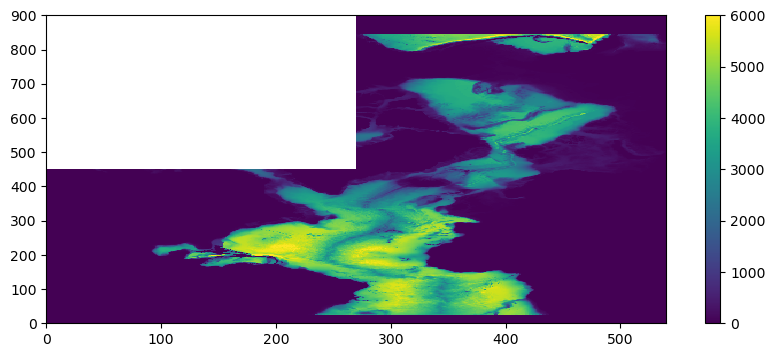

In [7]:
depth = mygrid['Depth']
plt.pcolormesh(get_aste_tracer(depth,nfx,nfy)[0])
plt.colorbar()
# plt.ylim(450,900)
# plt.xlim(200,540)

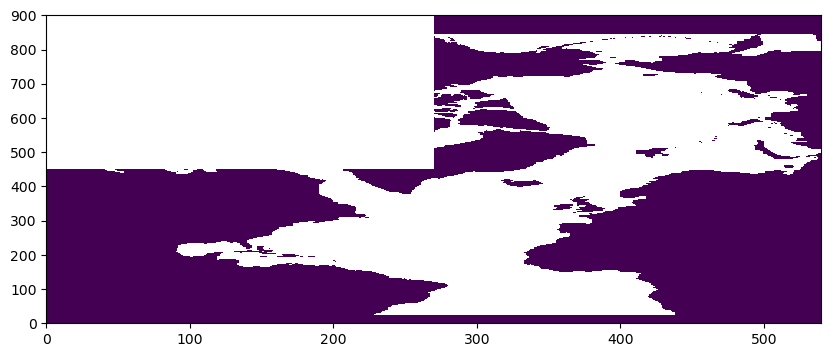

In [8]:
tmp = mygrid['hFacC'][0]
tmp[np.isnan(tmp)] = 2
tmp[tmp ==1 ] = np.nan

plt.pcolormesh(get_aste_tracer(tmp,nfx,nfy)[0])

In [9]:
fldout_depth = get_aste_faces(depth,nfx,nfy)
fldout_hfacC = get_aste_faces(tmp,nfx,nfy)

Text(0.5, 1.0, '5')

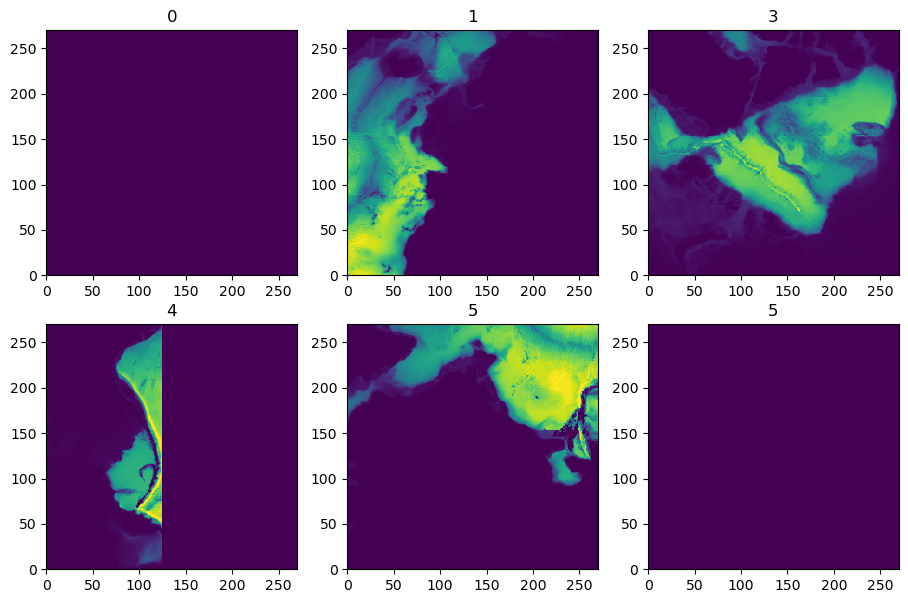

In [10]:
fig = plt.figure(figsize=(11,7))

ax = plt.subplot(231)
ax.pcolormesh(np.zeros((270,270)))
ax.set_title("0")

ax = plt.subplot(232)
ax.pcolormesh(fldout_depth.f1[0][-270:])
ax.set_title("1")

ax = plt.subplot(233)
ax.pcolormesh(fldout_depth.f3[0])
ax.set_title("3")

ax = plt.subplot(234)
tmp = fldout_depth.f4[0]
tmpf4 = np.zeros((270,270))
tmpf4[:,:180] = tmp
ax.pcolormesh(tmpf4)
ax.set_title("4")

ax = plt.subplot(235)
ax.pcolormesh(fldout_depth.f5[0][:,:270])
ax.set_title("5")

ax = plt.subplot(236)
ax.pcolormesh(np.zeros((270,270)))
ax.set_title("5")

# run the example

In [11]:
time = pd.date_range("2014-09-01", periods=1)
time

DatetimeIndex(['2014-09-01'], dtype='datetime64[ns]', freq='D')

In [14]:
# make some arrays based on the breakdown from above
# def prepfaces_xarr(fldout,time):
    # takes fldout from An's get_aste_faces
    # returns an array of shape time, depth, face, 270, 270 as an xarray

nz = fldout_depth.f3.shape[0]

# get the arrays as faces
f0 = np.zeros((fldout_depth.f3.shape[0],270,270))  # depth independent, will be of shape 1 if this is 2D
f1 = fldout_depth.f1[:,-270:,:]
f2 = fldout_depth.f3
f4 = fldout_depth.f5[:,:,:270]
f5 = np.zeros((fldout_depth.f3.shape[0],270,270))

# fill f4 becuse this is of width 180
tmp = fldout_depth.f4
f3 = np.zeros((nz,270,270))
f3[:,:,:180] = tmp

# reformulate as an xarray

# Define the dimensions and coordinates
time = pd.date_range("2014-09-01", periods=1)
nz = fldout_depth.f3.shape[0]
k = np.arange(nz)   # depth independent
tile = np.arange(6)
j = np.arange(270)
i_g = np.arange(270)

# Create the bigger array from the tiles
data = np.zeros((1,nz, 6, 270, 270))
data[:,:,0,:,:] = f0
data[:,:,1,:,:] = f1
data[:,:,2,:,:] = f2
data[:,:,3,:,:] = f3
data[:,:,4,:,:] = f4
data[:,:,5,:,:] = f5

# fill 0 with nan
data[data ==0] = np.nan

# Create the DataArray
xda = xr.DataArray(
    data=data,
    dims=["time","k", "tile", "j", "i_g"],
    coords={
        "time" : time,
        "k": k,
        "tile": tile,
        "j": j,
        "i_g": i_g
    },
    attrs={
        "standard_name": "depth",
        "long_name": "Ocean Depth",
        "units": "m"
    }
)

# # Display the DataArray
# xda

In [32]:
# make some arrays based on the breakdown from above
# def prepfaces_xarr(fldout,time):
    # takes fldout from An's get_aste_faces
    # returns an array of shape time, depth, face, 270, 270 as an xarray

nz = fldout_hfacC.f3.shape[0]

# get the arrays as faces
f0 = np.zeros((fldout_hfacC.f3.shape[0],270,270))  # depth independent, will be of shape 1 if this is 2D
f1 = fldout_hfacC.f1[:,-270:,:]
f2 = fldout_hfacC.f3
f4 = fldout_hfacC.f5[:,:,:270]
f5 = np.zeros((fldout_hfacC.f3.shape[0],270,270))

# fill f4 becuse this is of width 180
tmp = fldout_hfacC.f4
f3 = np.zeros((nz,270,270))
f3[:,:,:180] = tmp

# reformulate as an xarray

# Define the dimensions and coordinates
time = pd.date_range("2014-09-01", periods=1)
nz = fldout_hfacC.f3.shape[0]
k = np.arange(nz)   # depth independent
tile = np.arange(6)
j = np.arange(270)
i_g = np.arange(270)

# Create the bigger array from the tiles
data = np.zeros((1,nz, 6, 270, 270))
data[:,:,0,:,:] = f0
data[:,:,1,:,:] = f1
data[:,:,2,:,:] = f2
data[:,:,3,:,:] = f3
data[:,:,4,:,:] = f4
data[:,:,5,:,:] = f5

# fill 0 with nan
data[data ==0] = np.nan

# Create the DataArray
xda = xr.DataArray(
    data=data,
    dims=["time","k", "tile", "j", "i_g"],
    coords={
        "time" : time,
        "k": k,
        "tile": tile,
        "j": j,
        "i_g": i_g
    },
    attrs={
        "standard_name": "depth",
        "long_name": "Ocean Depth",
        "units": "m"
    }
)

# # Display the DataArray
# xda

In [33]:
# load a sample ASTE dataset -- maybe this will help us plot using the lat/long values
aste = llcreader.CRIOSPortalASTE270Model()
ds = aste.get_dataset()
ds = ds.sel(time='2014-09')

ClientResponseError: 500, message='Internal Server Error', url=URL('https://aste-release1.s3.us-east-2.amazonaws.com/masks.zarr/.zmetadata')

In [ ]:
ds = ds.rename({'face':'tile'})
cds = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [ ]:
del aste, ds

# make a new array of shape ny,nx of the lat and lon values from the dataset -- maybe this works easier

In [12]:
# # cds.data_vars['XC'][4].values.shape
# # lon[:,nfy[0]+nfy[2]+nfx[3]:nfy[0]+nfy[2]+nfx[3]+nfx[4],:]
# print(nfy[2])
# print(nfy[0])
# print(nx)
# print(nfy[0]+nfy[2])
# print(nfy[0]+nfy[2]+nfx[3])

In [13]:
# # for each idx in 6, put it in the data array
# lon = np.zeros((ny,nx))

# # from aste_faces2compact, copy syntax
# lon[nfy[0]-270:nfy[0],:] = cds.data_vars['XC'][1].values                                            # face 1
# lon[nfy[0]:nfy[0]+nfy[2],:] = cds.data_vars['XC'][2].values                                         # face 3
# lon[nfy[0]+nfy[2]:nfy[0]+nfy[2]+270,:] = cds.data_vars['XC'][3].values                              # face 4
# lon[nfy[0]+nfy[2]+nfx[3]:nfy[0]+nfy[2]+nfx[3]+270,:] = cds.data_vars['XC'][4].values                # face 5


# # do the same for lat
# lat = np.zeros((ny,nx))

# # from aste_faces2compact, copy syntax
# lat[nfy[0]-270:nfy[0],:] = cds.data_vars['YC'][1].values                                            # face 1
# lat[nfy[0]:nfy[0]+nfy[2],:] = cds.data_vars['YC'][2].values                                         # face 3
# lat[nfy[0]+nfy[2]:nfy[0]+nfy[2]+270,:] = cds.data_vars['YC'][3].values                              # face 4
# lat[nfy[0]+nfy[2]+nfx[3]:nfy[0]+nfy[2]+nfx[3]+270,:] = cds.data_vars['YC'][4].values                # face 5

In [14]:
# # now delete all variables that might be taking memory except lon,lat,depth
# del cds,xda,ds,aste,

In [15]:
# data = mygrid['Depth']

# lon[np.isnan(lon)] = np.nanmin(lon)-1 # fill with near values so as not to make error
# lat[np.isnan(lat)] = np.nanmin(lat)-1 # fill with near values so as not to make error

# data[(data < 30) & (lon < -97)] = np.nan

In [16]:
# # do a sample
# # subplot_kw = {"projection": ccrs.Orthographic(central_longitude=-45, central_latitude=50)}
# subplot_kw = {"projection": ccrs.Orthographic(central_longitude=0, central_latitude=90)}

# fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, figsize=(8, 8))
# #ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

# C = ax.pcolormesh(
#         lon,
#         lat,
#         data,  # first time step, 0 depth, tile
#         transform=ccrs.PlateCarree(),  # Project using PlateCarree for longitude/latitude
#         cmap='viridis',
#     )

# ax.set_global()
# ax.set_title("ASTE Depth")

# # print(1)

# # ax.coastlines()
# # ax.add_feature(cfeature.LAND, zorder=2, facecolor="0.75")  # Optional: Add land with specific color
# # ax.add_feature(cfeature.LAND, zorder=2, facecolor="0.75")  # Add land with a light grey color

# # print(2)

# # fig.colorbar(C, ax=ax, orientation='vertical', label="Depth (m)")
# # print(3)

# # plt.savefig('output_plot2.png', dpi=300)  # Save the plot as a PNG file

# previous attempts running into memory issues

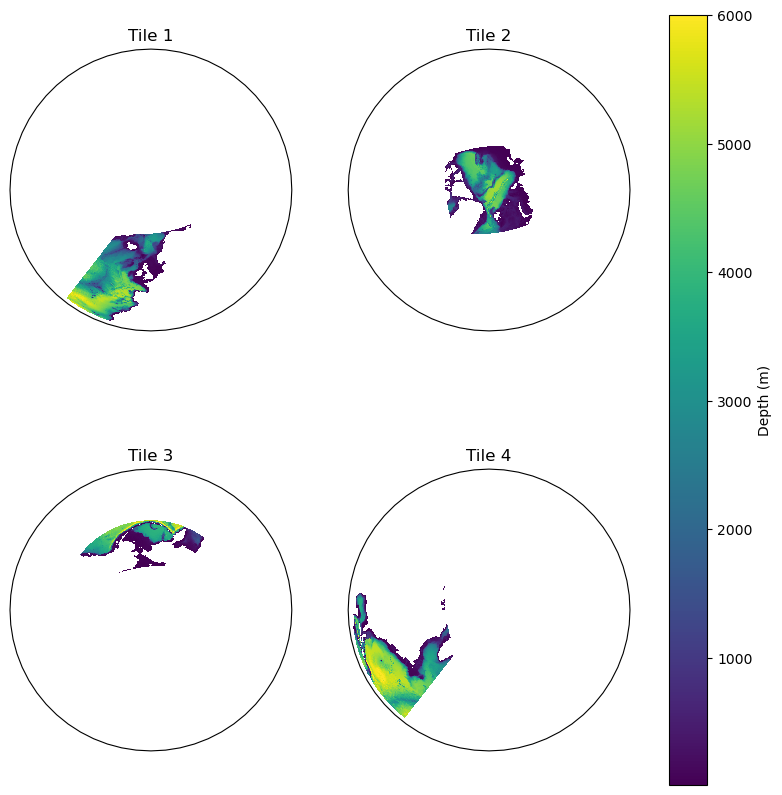

In [17]:
# do a sample
subplot_kw = {"projection": ccrs.Orthographic(central_longitude=0, central_latitude=90)}
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=subplot_kw, figsize=(10, 10))

for i,ax in enumerate(axes.flat):
    
    
    
    idx = i+1
    
    lon = cds.data_vars['XC'][idx].values
    lat = cds.data_vars['YC'][idx].values
    data = xda[0, 0, idx].values  # Select first time step and 0 depth for the tile
    
    data[np.isnan(lon)] = np.nan
    data[np.isnan(lat)] = np.nan

    lon[np.isnan(lon)] = np.nanmin(lon)-1 # fill with near values so as not to make error
    lat[np.isnan(lat)] = np.nanmin(lat)-1 # fill with near values so as not to make error

    if idx == 4:
        data[(data < 30) & (lon < -97)] = np.nan
    
    C = ax.pcolormesh(
            lon,
            lat,
            data,  # first time step, 0 depth, tile
            transform=ccrs.PlateCarree(),  # Project using PlateCarree for longitude/latitude
        )

    ax.set_global()
    
    #ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())
    ax.set_title("Tile " + str(idx))

# ax.coastlines()

fig.colorbar(C, ax=axes.ravel().tolist(), orientation='vertical',label="Depth (m)")

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

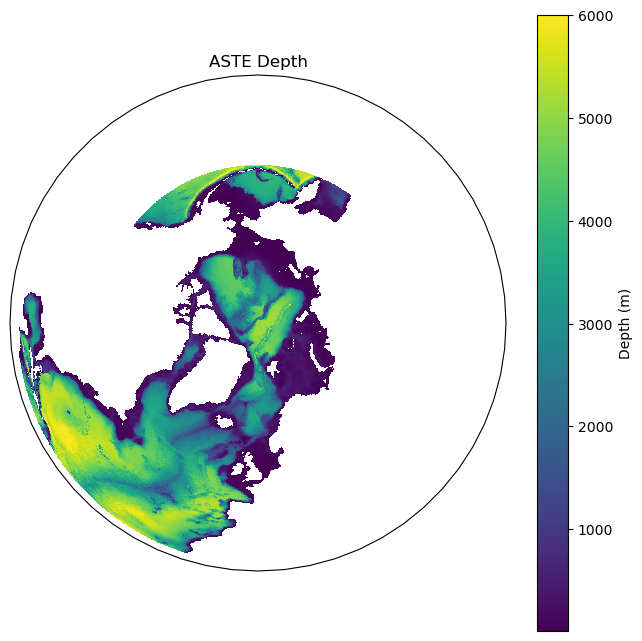

In [19]:
# do a sample
# subplot_kw = {"projection": ccrs.Orthographic(central_longitude=-45, central_latitude=50)}
subplot_kw = {"projection": ccrs.Orthographic(central_longitude=0, central_latitude=90)}

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, figsize=(8, 8))
#ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

for i in range(4):
    idx = i+1
    
    lon = cds.data_vars['XC'][idx].values
    lat = cds.data_vars['YC'][idx].values
    data = xda[0, 0, idx].values  # Select first time step and 0 depth for the tile
    
    
    lon[np.isnan(lon)] = np.nanmin(lon)-1 # fill with near values so as not to make error
    lat[np.isnan(lat)] = np.nanmin(lat)-1 # fill with near values so as not to make error
    data[np.isnan(lon)] = np.nan
    data[np.isnan(lat)] = np.nan    #print(latfill)
    
    C = ax.pcolormesh(
            lon,
            lat,
            data,  # first time step, 0 depth, tile
            transform=ccrs.PlateCarree(),  # Project using PlateCarree for longitude/latitude
            cmap='viridis',
        )
    
    ax.set_global()
    ax.set_title("ASTE Depth")

# print(1)

# ax.coastlines()
# ax.add_feature(cfeature.LAND, zorder=2, facecolor="0.75")  # Optional: Add land with specific color
# ax.add_feature(cfeature.LAND, zorder=2, facecolor="0.75")  # Add land with a light grey color

# print(2)

fig.colorbar(C, ax=ax, orientation='vertical', label="Depth (m)")
# print(3)

# plt.savefig('output_plot2.png', dpi=300)  # Save the plot as a PNG file

In [16]:

# Assuming cds and xda are already loaded as xarray objects

# Save xarray data to NumPy arrays
#lon_arrays = [cds.data_vars['XC'][idx].values for idx in range(1, 5)]
#lat_arrays = [cds.data_vars['YC'][idx].values for idx in range(1, 5)]
data_arrays = [xda[0, 0, idx].values for idx in range(1, 5)]

# del cds, xda


# Save the lon, lat, and data arrays to .npy files
for i in range(4):
    #np.save(f'lon_array_{i}.npy', lon_arrays[i])
    #np.save(f'lat_array_{i}.npy', lat_arrays[i])
    np.save(f'/home/mmurakami/crios_backups/ASTE_270/BarentsS_paper/npy_arrays/depth_{i}.npy', data_arrays[i])

# Optionally, you can delete the original arrays if no longer needed

In [ ]:
# Create the plot
subplot_kw = {"projection": ccrs.NorthPolarStereo()}
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=subplot_kw, figsize=(8, 8))

# Set the extent if needed (uncomment if you want to zoom in on 
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

for i in range(4):
    lon = lon_arrays[i]
    lat = lat_arrays[i]
    data = data_arrays[i]
    
    # Handle NaNs in lon, lat, and data
    lon[np.isnan(lon)] = np.nanmin(lon) - 1  # fill with near values to avoid errors
    lat[np.isnan(lat)] = np.nanmin(lat) - 1
    data[np.isnan(lon)] = np.nan
    data[np.isnan(lat)] = np.nan

    # Create the plot using pcolormesh
    C = ax.pcolormesh(
        lon,
        lat,
        data,  # First time step, 0 depth, tile
        transform=ccrs.PlateCarree(),  # Project using PlateCarree for longitude/latitude
        cmap='viridis',
    )
    
    ax.set_global()
    ax.set_title("ASTE Depth")

# Add a colorbar
fig.colorbar(C, ax=ax, orientation='vertical', label="Depth (m)")

# Optional: Uncomment to add coastlines or land features
# ax.coastlines()
# ax.add_feature(cfeature.LAND, zorder=2, facecolor="0.75")

# Save the plot if needed
# plt.savefig('output_plot2.png', dpi=300)

plt.show()

# try to combine the numbers before we plot